In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


In [3]:
#Can be done using one for loop
import zipfile

with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train.zip") as z:
    z.extractall(".")
with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train_masks.zip") as z:
    z.extractall(".")
with zipfile.ZipFile("/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip") as z:
    z.extractall(".")

In [7]:
import os
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import random
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image
# from torchvision.transforms import functional as F

In [5]:
len(os.listdir('/kaggle/working/train'))

5088

In [19]:
%config Completer.use_jedi = False

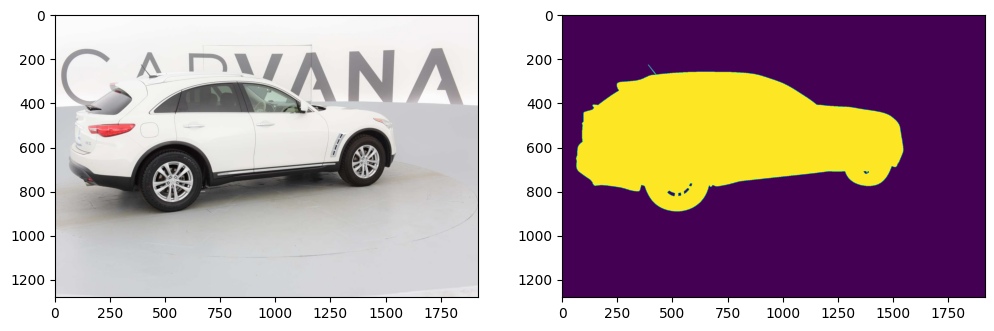

In [19]:
# for i in os.listdir('/kaggle/working/train'):
#very interesting thing. I always use random number fron numpy and use for loop. Use random.choice
i = random.choice(os.listdir('/kaggle/working/train'))
image = os.path.join('/kaggle/working/train',i)
im = cv2.imread(image)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
# plt.imshow(im)
file = i.replace('.jpg','_mask.gif')
mask = os.path.join('/kaggle/working/train_masks',file)
msk = Image.open(mask).convert('L')
# plt.imshow(msk)
fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].imshow(im)
axes[1].imshow(msk)

    # print(i)
    # break

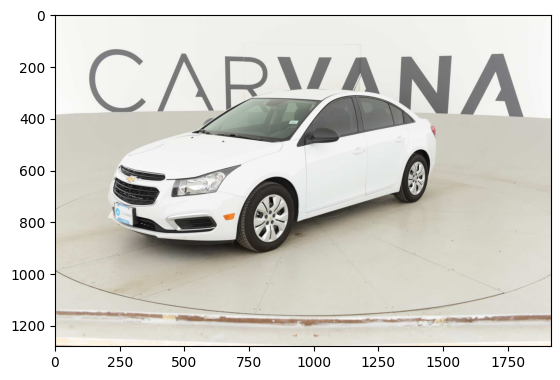

In [18]:
i = random.choice(os.listdir('/kaggle/working/train'))
image = os.path.join('/kaggle/working/train',i)
plt.imshow(np.array(Image.open(image).convert('RGB')))

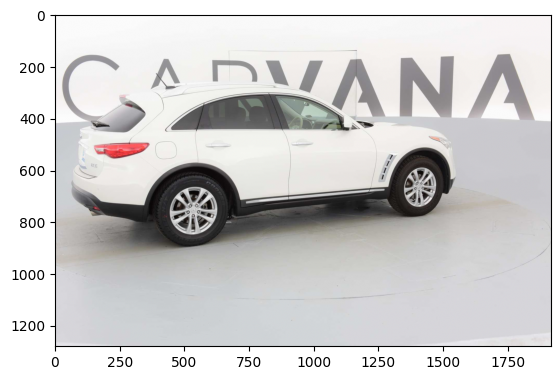

In [25]:
plt.imshow(np.array(Image.open(image).convert('RGB'))/255.0)

In [21]:
df = pd.read_csv('/kaggle/working/train_masks.csv')

In [22]:
df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


Next steps:
1. Dataset class
2. Create model
3. Train model

In [26]:
class CarvanaDataset(Dataset):
    def __init__(self,image_dir,mask_dir,transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        # return len(os.listdir(self.image_dir))
        return len(self.images)

    def __getitem__(self,idx):
        img_path = os.path.join(self.image_dir,self.images[idx])
        mask_path = os.path.join(self.mask_dir,self.images[idx].replace('.jpg','_mask.gif'))
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'),dtype=np.float32)
        mask = mask/255.0 #Normalize mask to 0 and 1

        if self.transforms is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
        return image,mask
        
        
    

In [33]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transforms = A.Compose([A.Resize(256,256),
                       A.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                       ToTensorV2()])

In [34]:
transforms

Compose([
  Resize(p=1.0, height=256, width=256, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [36]:
image_dir='/kaggle/working/train'
mask_dir='/kaggle/working/train_masks'
train_data = CarvanaDataset(image_dir,mask_dir)

In [37]:
train_data[0]

(array([[[231, 227, 228],
         [231, 227, 228],
         [231, 227, 228],
         ...,
         [233, 229, 230],
         [233, 229, 230],
         [233, 229, 230]],
 
        [[231, 227, 228],
         [231, 227, 228],
         [231, 227, 228],
         ...,
         [233, 229, 230],
         [233, 229, 230],
         [233, 229, 230]],
 
        [[231, 227, 228],
         [231, 227, 228],
         [231, 227, 228],
         ...,
         [233, 229, 230],
         [233, 229, 230],
         [233, 229, 230]],
 
        ...,
 
        [[183, 187, 190],
         [183, 187, 190],
         [183, 187, 190],
         ...,
         [213, 185, 173],
         [213, 185, 173],
         [214, 186, 174]],
 
        [[183, 187, 190],
         [183, 187, 190],
         [183, 187, 190],
         ...,
         [215, 183, 170],
         [214, 182, 169],
         [214, 182, 169]],
 
        [[183, 187, 190],
         [183, 187, 190],
         [183, 187, 190],
         ...,
         [213, 180, 165],
  